In [2]:
import filegetter.filegetter as fgt
import pandas as pd
df = fgt.get("binance", "swap", "btc-usdt", "trade","20250318", machine="AWS-JP1")
dg = fgt.get("binance", "swap", "btc-usdt", "depth5","20250318", machine="AWS-JP1")
trades_df=df


loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_TRADE_2025_03_18.hdf 
loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_DEPTH5_2025_03_18.hdf 


In [3]:
import filegetter.filegetter as fgt
import pandas as pd
df = fgt.get("binance", "swap", "btc-usdt", "trade","20250318", machine="AWS-JP1")
dg = fgt.get("binance", "swap", "btc-usdt", "depth5","20250318", machine="AWS-JP1")
trades_df=df


loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_TRADE_2025_03_18.hdf 


loading... AWS-JP1_BINANCE_SWAP_BTC-USDT_DEPTH5_2025_03_18.hdf 


In [6]:
df

,p,v,ts,local_time,upload_time,source,trade_id
0,83963.0,0.398,1742256004820,1742256004825121767,1742256004852139726,NaN,6113553678
1,83963.0,0.215,1742256004820,1742256004825126770,1742256004852139726,NaN,6113553679
2,83963.0,0.001,1742256004821,1742256004825139498,1742256004852139726,NaN,6113553680
3,83963.0,0.387,1742256004821,1742256004825142119,1742256004852139726,NaN,6113553681
4,83963.0,0.020,1742256004821,1742256004825144440,1742256004852139726,NaN,6113553682
...,...,...,...,...,...,...,...
3166246,82666.1,-0.006,1742342398268,1742342398270669824,1742342398270712758,NaN,6116788695
3166247,82666.2,0.060,1742342398412,1742342398413824483,1742342398413845542,NaN,6116788696
3166248,82666.1,-0.014,1742342398520,1742342398521849402,1742342398521855776,NaN,6116788697
3166249,82666.2,0.002,1742342398819,1742342398821287085,1742342398821292412,NaN,6116788698


In [7]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import poisson
from numba import njit
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression


In [ ]:
# ===============================================================
# 0. 载入并对齐逐笔 + 盘口，得到 delta_tick 与 q_front
# ===============================================================
import pandas as pd, numpy as np

TICK_SIZE = 0.1
TRADES_TOLERANCE = "100ms"       # 成交 → 盘口 最大回溯

# --- 0‑1 逐笔、盘口 -> DateTimeIndex ---------------------------
trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()

dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

# --- 0‑2 merge_asof: 把最近一次盘口贴到成交 --------------------
merged = pd.merge_asof(
    left  = trades_df.reset_index(),
    right = dg.reset_index(),
    on="datetime",
    direction="backward",
    tolerance=pd.Timedelta(TRADES_TOLERANCE)
).set_index("datetime").dropna(subset=["bp1","ap1"])  # 丢掉无法匹配的

# --- 0‑3 计算 mid 与 delta_tick -------------------------------
merged["mid"] = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged = merged[merged["delta_tick"] != 0]            # mid 档过滤

# --- 0‑4 计算同档排队深度 q_front ------------------------------
def depth_same_row(row, max_lv=5):
    d = int(row["delta_tick"])
    lv = max(1, min(abs(d), max_lv))      # 档位号 1~5
    return row[f"bv{lv}"] if d < 0 else row[f"av{lv}"]

merged["q_front"] = merged.apply(depth_same_row, axis=1).astype(float)

# 还可选：累加前档深度（吃 bp4 必须先吃 bp1‑bp3）
def cumsum_depth(row, max_lv=5):
    d = int(row["delta_tick"])
    if d < 0:
        return sum(row[f"bv{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
    else:
        return sum(row[f"av{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
merged["q_front_cum"] = merged.apply(cumsum_depth, axis=1).astype(float)

# ===============================================================
# 1.1 只用“总成交流”拟合单维 Hawkes(μ, alpha, β)
# ===============================================================
from tick.hawkes import HawkesExpKern

events_sec = (merged.index.astype("int64") / 1e9).values.astype(float)   # 秒
t0_sec     = events_sec[0]
events_sec = events_sec - t0_sec                                         # 从 0 开始

hawkes = HawkesExpKern(decays=[[4.0]], max_iter=100)
hawkes.fit([events_sec])

mu, alpha = hawkes.baseline[0], hawkes.adjacency[0,0]
beta      = float(np.asarray(hawkes.decays)[0,0])
print(f"μ={mu:.3f}  alpha={alpha:.3f}  β={beta:.3f}  n={alpha/beta:.2f}")

# ===============================================================
# 1.2 闭式函数：λ(t)  &  未来 T 秒期望成交 Λ(T)
# ===============================================================
from numba import njit

@njit
def lambda_now(t_now, events, mu, alpha, beta, lookback=3.0):
    """滚动窗口 3 s 计算 λ(t)"""
    s = 0.0
    for i in range(len(events)-1, -1, -1):
        dt = t_now - events[i]
        if dt > lookback: break
        if dt > 0:
            s += alpha * np.exp(-beta*dt)
    return mu + s

def expected_fills(l0, mu, beta, T):
    return mu*T + (l0-mu)*(1-np.exp(-beta*T))/beta

# ===============================================================
# 1.3 完全成交概率 (Poisson 尾) – 传入 ANY need
# ===============================================================
from scipy.stats import poisson
def fill_prob(q_need, wait_sec, l0=None, t_now=None):
    if l0 is None:
        l0 = lambda_now(t_now, events_sec, mu, alpha, beta)
    Λ = expected_fills(l0, mu, beta, wait_sec)
    return 1 - poisson.cdf(q_need-1, Λ)


μ=0.997  α=0.988  β=4.000  n=0.25


In [24]:
wait_sec = 2
q_my     = 3
row = merged.sample(1).iloc[0]
t_now    = (row.name.value / 1e9) - t0_sec

need = row["q_front_cum"] + q_my
prob = fill_prob(need, wait_sec, t_now=t_now)
print(f"time={row.name}, Δ={row['delta_tick']:+}, need={need:.0f}手, "
      f"P(fill {wait_sec}s)={prob:.8%}")

time=2025-03-18 21:15:05.560000, Δ=-74, need=3手, P(fill 2s)=100.00000000%


In [42]:
SAMPLE_MS  = "5ms"
# ===============================================================
# 2. λ0(t) — Numba
# ===============================================================
@njit
def lambda_series(events, tgrid, mu, alpha, beta, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        s = 0.0
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            s += alpha * np.exp(-beta*dt)
        lam[i] = mu + s
    return lam

samples = (merged[["q_front_cum"]].resample(SAMPLE_MS).first().dropna())
t_grid  = samples.index.view("int64")/1e9
lambda0 = lambda_series(events_sec, t_grid, mu, alpha, beta)
samples["λ0"] = lambda0

# ===============================================================
# 3. Λ(T)、need、原始概率 P_raw
# ===============================================================
q_my_list = [0.1,0.3,0.5,1.0,2,3,4]
T_list    = [0.1, 0.3, 0.5,1.0,2,3,4]

L0   = lambda0[:, None]
T_arr= np.array(T_list)[None, :]
Lambda = mu*T_arr + (L0-mu)*(1-np.exp(-beta*T_arr))/beta

q_front = samples["q_front_cum"].to_numpy()[:, None]
q_my_arr= np.array(q_my_list)[None, :]
need    = q_front + q_my_arr

P_raw = 1 - poisson.cdf(need[:, None, :] - 1, Lambda[:, :, None])

# ===============================================================
# 4. Platt‑scaling 校准  （★ 修正版使用安全 cumvol）
# ===============================================================
def prefix_sum_with_zero(vol):
    return np.concatenate(([0.], np.cumsum(vol, dtype=float)))  # ★

evt_time = merged.index.view("int64")/1e9 - t0_sec
evt_vol  = merged["v"].abs().to_numpy()
cumvol   = prefix_sum_with_zero(evt_vol)                         # ★

P_cal = np.full_like(P_raw, np.nan)

for j, T in enumerate(T_list):
    # — 预计算窗口成交量矩阵 fills[:, j] ------------------------- ★
    right = np.searchsorted(evt_time, (t_grid - t0_sec) + T, side="right")
    left  = np.searchsorted(evt_time, (t_grid - t0_sec),   side="right")
    fills_T = cumvol[right] - cumvol[left]                     # shape (N,)
    for k, q in enumerate(q_my_list):
        p = P_raw[:, j, k]
        y = (fills_T >= need[:, k]).astype(int)

        mask = ~np.isnan(p)
        if mask.sum() < 1000 or y[mask].ptp()==0:
            continue

        from sklearn.model_selection import train_test_split

        X = p[mask].reshape(-1, 1)
        y_vec = y[mask]

        X_tr, X_te, y_tr, y_te = train_test_split(
                X, y_vec, test_size=0.2, random_state=42, shuffle=True)

        lr = LogisticRegression(solver="lbfgs", C=1e6, max_iter=200).fit(X_tr, y_tr)

        # --- 把校准概率写回所有样本 ---------------------------------
        P_cal[mask, j, k] = lr.predict_proba(p[mask].reshape(-1,1))[:, 1]
# ===============================================================
# 5. Brier / AUC
# ===============================================================
records = []
for j, T in enumerate(T_list):
    fills_T = cumvol[np.searchsorted(evt_time, (t_grid - t0_sec) + T, side="right")] \
            - cumvol[np.searchsorted(evt_time, (t_grid - t0_sec),   side="right")]
    for k, q in enumerate(q_my_list):
        p = P_cal[:, j, k]
        y = (fills_T >= need[:, k]).astype(int)
        mask = ~np.isnan(p)
        if mask.sum() < 500:
            continue
        brier = brier_score_loss(y[mask], p[mask])
        auc   = np.nan if y[mask].ptp()==0 else roc_auc_score(y[mask], p[mask])
        records.append((q, T, mask.sum(), brier, auc))

result = pd.DataFrame(records, columns=["q_my","T","N","Brier","AUC"]) \
           .sort_values("Brier")
print("采样点数 =", len(samples))
print(result.head(20))



采样点数 = 584460
    q_my    T       N     Brier       AUC
6    4.0  0.1  584460  0.019865  0.818019
5    3.0  0.1  584460  0.024612  0.821240
4    2.0  0.1  584460  0.032095  0.822617
3    1.0  0.1  584460  0.046151  0.829690
13   4.0  0.3  584460  0.046407  0.817437
12   3.0  0.3  584460  0.055332  0.817803
2    0.5  0.1  584460  0.061100  0.799063
20   4.0  0.5  584460  0.067624  0.810222
11   2.0  0.3  584460  0.068140  0.818967
1    0.3  0.1  584460  0.070636  0.808612
19   3.0  0.5  584460  0.078580  0.809233
0    0.1  0.1  584460  0.086826  0.832409
10   1.0  0.3  584460  0.088898  0.824074
18   2.0  0.5  584460  0.093653  0.811412
9    0.5  0.3  584460  0.106665  0.807755
27   4.0  1.0  584460  0.109475  0.796174
17   1.0  0.5  584460  0.115379  0.818846
8    0.3  0.3  584460  0.115410  0.820469
26   3.0  1.0  584460  0.122083  0.797386
7    0.1  0.3  584460  0.124834  0.845820


In [43]:
print(result)

    q_my    T       N     Brier       AUC
6    4.0  0.1  584460  0.019865  0.818019
5    3.0  0.1  584460  0.024612  0.821240
4    2.0  0.1  584460  0.032095  0.822617
3    1.0  0.1  584460  0.046151  0.829690
13   4.0  0.3  584460  0.046407  0.817437
12   3.0  0.3  584460  0.055332  0.817803
2    0.5  0.1  584460  0.061100  0.799063
20   4.0  0.5  584460  0.067624  0.810222
11   2.0  0.3  584460  0.068140  0.818967
1    0.3  0.1  584460  0.070636  0.808612
19   3.0  0.5  584460  0.078580  0.809233
0    0.1  0.1  584460  0.086826  0.832409
10   1.0  0.3  584460  0.088898  0.824074
18   2.0  0.5  584460  0.093653  0.811412
9    0.5  0.3  584460  0.106665  0.807755
27   4.0  1.0  584460  0.109475  0.796174
17   1.0  0.5  584460  0.115379  0.818846
8    0.3  0.3  584460  0.115410  0.820469
26   3.0  1.0  584460  0.122083  0.797386
7    0.1  0.3  584460  0.124834  0.845820
16   0.5  0.5  584460  0.130921  0.811213
15   0.3  0.5  584460  0.136600  0.824971
25   2.0  1.0  584460  0.136776  0

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

[buy]  μ=0.991 α1=0.980 α2=0.982
[sell] μ=0.990 α1=0.986 α2=0.986


/home/luchen/filegetter-1/.venv/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:336: RuntimeWarning: divide by zero encountered in _nbinom_cdf
  return _boost._nbinom_cdf(k, n, p)


采样点 = 584460
    q_my    T       N     Brier       AUC
6    4.0  0.1  584460  0.043186  0.811830
5    3.0  0.1  584460  0.052611  0.814853
4    2.0  0.1  584460  0.065033  0.815820
3    1.0  0.1  584460  0.081443  0.822118
13   4.0  0.3  584460  0.092476  0.812319
2    0.5  0.1  584460  0.100292  0.796432
12   3.0  0.3  584460  0.100720  0.812264
1    0.3  0.1  584460  0.104830  0.806380
0    0.1  0.1  584460  0.109141  0.830441
11   2.0  0.3  584460  0.110288  0.812746
20   4.0  0.5  584460  0.112440  0.806596
19   3.0  0.5  584460  0.120058  0.804755
10   1.0  0.3  584460  0.122199  0.816433
18   2.0  0.5  584460  0.128766  0.805533
9    0.5  0.3  584460  0.132387  0.804242


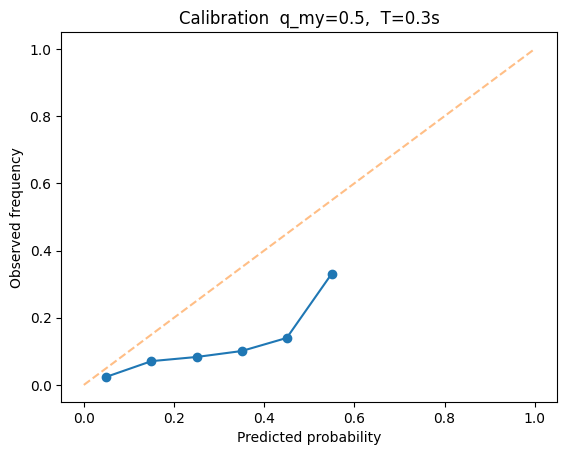

In [10]:
# ===============================================================
# 双边 + 双β(12 & 1.5) 近似双核 Hawkes  + NB 尾  + Platt 校准
# 兼容 tick 0.7.x
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------
TICK_SIZE, TRADES_TOL = 0.1, "100ms"

trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()
dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TRADES_TOL))
            .set_index("datetime")
            .dropna(subset=["bp1","ap1"]))

merged["mid"] = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged = merged[merged["delta_tick"] != 0]

def q_cum(row, max_lv=5):
    d = int(row["delta_tick"])
    rng = range(1, min(abs(d), max_lv)+1)
    return (sum(row[f"bv{lv}"] for lv in rng) if d < 0
            else sum(row[f"av{lv}"] for lv in rng))
merged["q_front_cum"] = merged.apply(q_cum, axis=1)

# --------------------- 1. 事件拆分 ------------------------------
mask_buy  = merged["v"] > 0      # 主动买
mask_sell = merged["v"] < 0      # 主动卖
def to_sec(obj):
    """
    Timestamp  → obj.value / 1e9
    Index/Series/ndarray → .view("int64") / 1e9
    """
    if hasattr(obj, "value"):          # 标量 Timestamp
        return obj.value / 1e9
    else:                              # 向量化对象
        return obj.view("int64") / 1e9

t0_sec = to_sec(merged.index[0]) 
ev_buy  = (to_sec(merged.index[mask_buy ]) - t0_sec).astype(float)
ev_sell = (to_sec(merged.index[mask_sell]) - t0_sec).astype(float)

# --------------------- 2. “双拟合” 取得 μ̂, α1, α2 --------------
β_short, β_long = 12.0, 1.5      # 80 ms vs 0.7 s 记忆

def fit_one_beta(events, beta_fixed):
    # ← 单核也写成 1×1 矩阵
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    mu  = hk.baseline[0]
    alp = hk.adjacency[0, 0]
    return mu, alp

μ1_b, α1_b = fit_one_beta(ev_buy , β_short)
μ2_b, α2_b = fit_one_beta(ev_buy , β_long)
μb_hat     = 0.5*(μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_short)
μ2_s, α2_s = fit_one_beta(ev_sell, β_long)
μs_hat     = 0.5*(μ1_s + μ2_s)

print(f"[buy]  μ={μb_hat:.3f} α1={α1_b:.3f} α2={α2_b:.3f}")
print(f"[sell] μ={μs_hat:.3f} α1={α1_s:.3f} α2={α2_s:.3f}")

# --------------------- 3. λ0(t) 近似双核 -------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1*np.exp(-β1*dt) + α2*np.exp(-β2*dt)
        lam[i] = μ + acc
    return lam

SAMPLE_MS = "5ms"
samples = (merged[["delta_tick","q_front_cum"]]
           .resample(SAMPLE_MS).first().dropna())
t_grid   = samples.index.view("int64") / 1e9

λ_buy  = lambda_dual(ev_buy , t_grid, μb_hat, α1_b, α2_b, β_short, β_long)
λ_sell = lambda_dual(ev_sell, t_grid, μs_hat, α1_s, α2_s, β_short, β_long)
λ0 = np.where((samples["delta_tick"] > 0).to_numpy(), λ_buy, λ_sell)

# --------------------- 4. Λ(T) + NB 尾概率 -----------------------
q_my_list = [0.1,0.3,0.5,1,2,3,4]
T_list    = [0.1,0.3,0.5,1,2,3,4]
κ         = 1.8

L0   = λ0[:,None]
T_arr= np.array(T_list)[None,:]
Λ    = μb_hat*T_arr + (L0-μb_hat)*(1-np.exp(-β_long*T_arr))/β_long

need = samples["q_front_cum"].to_numpy()[:,None] + np.array(q_my_list)[None,:]
def nb_tail(n, Lam, kappa):
    Lam = np.maximum(Lam, 1e-12)        # 避免 Λ=0
    kappa = max(kappa, 1.0001)          # 避免 κ=1
    r = Lam / (kappa - 1)
    p = 1 / kappa
    return 1 - nbinom.cdf(n - 1, r, p)

P_raw = nb_tail(need[:,None,:], Λ[:,:,None], κ)

# --------------------- 5. label --------------------------------
cumvol = np.concatenate(([0.], np.cumsum(merged["v"].abs())))
evt_time = merged.index.view("int64")/1e9 - t0_sec
def fills(T):
    right = np.searchsorted(evt_time, (t_grid-t0_sec)+T, 'right')
    left  = np.searchsorted(evt_time, (t_grid-t0_sec),   'right')
    return cumvol[right]-cumvol[left]
fills_mat = np.vstack([fills(T) for T in T_list]).T
label = fills_mat[:,:,None] >= need[:,None,:]

# --------------------- 6. Platt 校准 ----------------------------
mask = ~np.isnan(P_raw)
X = P_raw[mask].reshape(-1,1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])
P_cal = np.full_like(P_raw, np.nan)
P_cal[mask] = platt.predict_proba(X)[:,1]

# --------------------- 7. 回测指标 ------------------------------
records=[]
for j, T in enumerate(T_list):
    for k, q in enumerate(q_my_list):
        p = P_cal[:, j, k]
        y = label[:, j, k]
        m = ~np.isnan(p)
        if m.sum() < 500 or y[m].astype(int).ptp() == 0:   # ← 修正处
            continue
        brier = brier_score_loss(y[m], p[m])
        auc   = roc_auc_score(y[m], p[m])                  # 安全：此处已确保两类都有
        records.append((q, T, m.sum(), brier, auc))
result = (pd.DataFrame(records,columns=["q_my","T","N","Brier","AUC"])
            .sort_values("Brier"))
print("采样点 =", len(samples))
print(result.head(15))

# --------------------- 8. 校准曲线 ------------------------------
# -------- 校准曲线 (改写) ------------------------------------
sel_q, sel_T = 0.5, 0.3
j, k = T_list.index(sel_T), q_my_list.index(sel_q)

m   = ~np.isnan(P_cal[:, j, k])
bins = pd.cut(P_cal[m, j, k], bins=np.linspace(0, 1, 11))

cal  = pd.Series(label[m, j, k]).groupby(bins).mean()   # Series index = categories

# 取中点
x_mid = cal.index.map(lambda iv: iv.mid)   # ← Interval → float
y_val = cal.values

plt.plot(x_mid, y_val, "o-")
plt.plot([0, 1], [0, 1], "--", alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  q_my={sel_q},  T={sel_T}s")
plt.show()
